<a href="https://colab.research.google.com/github/FrancisKurian/CS530/blob/main/CS530_hw5_Logistics_Regression_with_Ridge_Lasso_ElasticNet_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving adult.test to adult.test
Saving adult.data to adult.data


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc,matthews_corrcoef

#Data Preperation and Cleaning

In [ ]:
df_tr = pd.read_csv('adult.data',header=None)
df_te = pd.read_csv('adult.test',header=None)
col= ['age', 'workclass',  'fnlwgt',  'education',  'education_num',  'marital_status',  'occupation',  'relationship',  'race',  'sex',  'capital_gain',  'capital_loss',  'hours_per_week',  'native_country','Income'  ] 
df=pd.concat([df_tr, df_te], ignore_index=True)
df.columns= col
df['education']=df['education'].str.strip()
df['workclass']=df['workclass'].str.strip()
df['marital_status']=df['marital_status'].str.strip()
df['occupation']=df['occupation'].str.strip()
df['native_country']=df['native_country'].str.strip()

df.loc[df['education'].isin(['Preschool','1st-4th','5th-6th','7th-8th','9th']), 'education'] = 'Pre 10th'
df.loc[df['workclass'].isin(['Without-pay','Never-worked','?']), 'workclass'] = 'Unknown'
df.loc[df['marital_status'].isin(['Married-spouse-absent','Married-AF-spouse']), 'marital_status'] = 'Separated'
df.loc[df['occupation'].isin(['Priv-house-serv','Armed-Forces','?']), 'occupation'] = 'Miscellanious'
df.loc[df['native_country'] !='United-States', 'native_country'] = 'Non United-States'  


# result = []
# for value in df["age"]:
#     if value <= 33:
#         result.append("LT 33")
#     elif value < 58:
#         result.append("GT 33 LT 58")
#     else:
#         result.append("Plus 58")
       
# df["age_grp"] = result   

# result = []
# for value in df["hours_per_week"]:
#     if value <= 40:
#         result.append("LT 40")
#     else:
#         result.append("GT 40")
       
# df["hours_grp"] = result   

# Probability of income >50k, treat the coding mismatch   
df["Income"].replace({' >50K' : 1,' >50K.' : 1, ' <=50K' : 0,' <=50K.' : 0,},inplace=True)
drop = ['education_num','fnlwgt' ] # removing did not reduce the overall prediction
df.drop(drop, axis=1, inplace=True)
df.insert(0, 'constant', value=1)
df2=df.copy()

In [ ]:
df['Income'].value_counts() 

0    37155
1    11687
Name: Income, dtype: int64

# One Hot Encoding of categorical fields (k-1 categories)

In [ ]:
cat_colums=df.select_dtypes(include='object').columns

In [ ]:
encoder=OneHotEncoder(drop='first', sparse=False)
# encoder=OneHotEncoder(sparse=False)
df_encoded = pd.DataFrame (encoder.fit_transform(df[cat_colums]))
df_encoded.columns = encoder.get_feature_names_out(cat_colums)
df.drop(cat_colums ,axis=1, inplace=True)
df_oh= pd.concat([df, df_encoded ], axis=1)
df_oh.head()

,constant,age,capital_gain,capital_loss,hours_per_week,Income,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,native_country_United-States
0,1,39,2174,0,40,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,1,50,0,0,13,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
2,1,38,0,0,40,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,1,53,0,0,40,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,1,28,0,0,40,0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_oh.drop(['Income'], axis=1), df_oh['Income'], test_size=0.333333, random_state=88)

In [ ]:
X_train.head()

,constant,age,capital_gain,capital_loss,hours_per_week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Male,native_country_United-States
6359,1,75,0,0,20,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
21709,1,25,0,0,35,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
6170,1,45,0,0,55,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
19752,1,32,2407,0,40,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
20307,1,47,0,0,40,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [ ]:
print(X_train.shape, y_train.shape)

(32561, 49) (32561,)


In [ ]:
cat_columns = df2.select_dtypes(['object']).columns
df2[cat_columns] = df2[cat_columns].apply(lambda x: pd.factorize(x)[0])
df2.head()

,constant,age,workclass,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Income
0,1,39,0,0,0,0,0,0,0,2174,0,40,0,0
1,1,50,1,0,1,1,1,0,0,0,0,13,0,0
2,1,38,2,1,2,2,0,0,0,0,0,40,0,0
3,1,53,2,2,1,2,1,1,0,0,0,40,0,0
4,1,28,2,0,1,3,2,1,1,0,0,40,1,0


In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(df2.drop(['Income'], axis=1), df2['Income'], test_size=0.333333, random_state=88)

In [ ]:
print(X2_train.shape, y2_train.shape,X2_test.shape, y2_test.shape)

(32561, 13) (32561,) (16281, 13) (16281,)


# Base Model - Logistics Regression with no regularization vs  k-nearest (KNN) neighbors 
## Trained with 66.6%; tested on 33% of random sample.

In [ ]:
clf = KNeighborsClassifier(n_neighbors=4).fit(X2_train,y2_train)
y_pred=clf.predict(X2_test) 
ac_nb=clf.score(X2_test, y2_test)
mc_nb=matthews_corrcoef(y2_test, y_pred)
probs = clf.predict_proba(X2_test)[:,1]
fpr_nb, tpr_nb, threshs_nb = roc_curve(y2_test, probs)
roc_auc_nb = auc(fpr_nb, tpr_nb)

print(f'The accuracy of Naive Bayes with no regularization is: {ac_nb:.5}')
print(f'Mattews Correlation Coefficient is: {mc_nb:.5}')

The accuracy of Naive Bayes with no regularization is: 0.84024
Mattews Correlation Coefficient is: 0.52027


In [ ]:
clf = LogisticRegression(random_state=0,penalty="none",max_iter=5000).fit(X_train, y_train)
y_pred=clf.predict(X_test) 
ac_lr=clf.score(X_test, y_test)
mc_lr=matthews_corrcoef(y_test, y_pred)
probs = clf.predict_proba(X_test)[:,1]
fpr_lg, tpr_lg, threshs_lg = roc_curve(y_test, probs)
roc_auc_lg = auc(fpr_lg, tpr_lg)

print(f'The accuracy of Logistic Regression with no regularization is: {ac_lr:.5}')
print(f'Mattews Correlation Coefficient is: {mc_lr:.5}')

The accuracy of Logistic Regression with no regularization is: 0.85124
Mattews Correlation Coefficient is: 0.56746


# Determination of hyperparameters for logistics regression(K-fold=5)

In [ ]:
from sklearn.model_selection import GridSearchCV
logModel = LogisticRegression()
def hsearch (penalty,solver,iter, l1_ratio,cv):
  param_grid = [    
    {'penalty' : [penalty],
    'C' :  np.logspace(-4, 4, 50),
    'solver' : [solver],
    'max_iter' : [iter],
    'l1_ratio':[l1_ratio]
    }
]
  clf = GridSearchCV(logModel, param_grid = param_grid, cv = cv, scoring='accuracy', verbose=3, n_jobs=-1)
  best_clf = clf.fit(X_train,y_train)
  print(best_clf.best_estimator_)
  print (f'Accuracy - : {best_clf.score(X_test,y_test):.3f}')
  return best_clf.best_estimator_

In [ ]:
# be_l1=hsearch(penalty='l1',solver='liblinear',iter=5000, l1_ratio=0.2,cv=5)
# be_l2=hsearch(penalty='l2',solver='newton-cg',iter=5000, l1_ratio=0.2,cv=5)
# be_e=hsearch(penalty='elasticnet',solver='saga',iter=5000, l1_ratio=0.8,cv=5)

# Comparison of Lasso(l1), Ridge(l2), ElasticNet regularization on Test data

## Lasso(L1)

In [ ]:
clf = LogisticRegression(C=24.420530945486497, l1_ratio=0.2, max_iter=5000,penalty='l1', solver='liblinear').fit(X_train, y_train)
ac_lr_tr=clf.score(X_train, y_train)
y_pred=clf.predict(X_test) 
ac_lr=clf.score(X_test, y_test)
mc_lr=matthews_corrcoef(y_test, y_pred)
probs = clf.predict_proba(X_test)[:,1]
fpr_lg_l1, tpr_lg_l1, threshs_lg_l1 = roc_curve(y_test, probs)
roc_auc_lg_l1 = auc(fpr_lg_l1, tpr_lg_l1)
print(f'The accuracy of Logistic Regression with Lasso(L1/Training) is: {ac_lr_tr:.5}')
print(f'The accuracy of Logistic Regression with Lasso(L1/Test) is: {ac_lr:.5}')
print(f'Mattews Correlation Coefficient is: {mc_lr:.5}')
print(f'ROC-Area Under the Curve(AUC) is: {roc_auc_lg_l1:.5}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)


The accuracy of Logistic Regression with Lasso(L1/Training) is: 0.85148
The accuracy of Logistic Regression with Lasso(L1/Test) is: 0.85345
Mattews Correlation Coefficient is: 0.57478
ROC-Area Under the Curve(AUC) is: 0.90553


##Ridge (L2)

In [ ]:
clf = LogisticRegression(C=35.564803062231285,max_iter=5000,solver='newton-cg').fit(X_train, y_train)
y_pred=clf.predict(X_test) 
ac_lr=clf.score(X_test, y_test)
mc_lr=matthews_corrcoef(y_test, y_pred)
probs = clf.predict_proba(X_test)[:,1]
fpr_lg_l2, tpr_lg_l2, threshs_lg_l2 = roc_curve(y_test, probs)
roc_auc_lg_l2 = auc(fpr_lg_l2, tpr_lg_l2)
print(f'The accuracy of Logistic Regression with Ridge(L2 Regularization) is: {ac_lr:.5}')
print(f'Mattews Correlation Coefficient is: {mc_lr:.5}')
print(f'ROC-Area Under the Curve(AUC) is: {roc_auc_lg_l2:.5}')

The accuracy of Logistic Regression with Ridge(L2 Regularization) is: 0.8524
Mattews Correlation Coefficient is: 0.57186
ROC-Area Under the Curve(AUC) is: 0.90623


##ElasticNet

In [ ]:
clf = LogisticRegression(C=0.00021209508879201905, l1_ratio=0.2, max_iter=5000,penalty='elasticnet', solver='saga').fit(X_train, y_train)
y_pred=clf.predict(X_test) 
ac_lr=clf.score(X_test, y_test)
mc_lr=matthews_corrcoef(y_test, y_pred)
probs = clf.predict_proba(X_test)[:,1]
fpr_lg_en, tpr_lg_en, threshs_lg_en = roc_curve(y_test, probs)
roc_auc_lg_en = auc(fpr_lg_en, tpr_lg_en)
print(f'The accuracy of Logistic Regression with Ridge(L2 Regularization) is: {ac_lr:.5}')
print(f'Mattews Correlation Coefficient is: {mc_lr:.5}')
print(f'ROC-Area Under the Curve(AUC) is: {roc_auc_lg_en:.5}')

The accuracy of Logistic Regression with Ridge(L2 Regularization) is: 0.79805
Mattews Correlation Coefficient is: 0.33611
ROC-Area Under the Curve(AUC) is: 0.48314


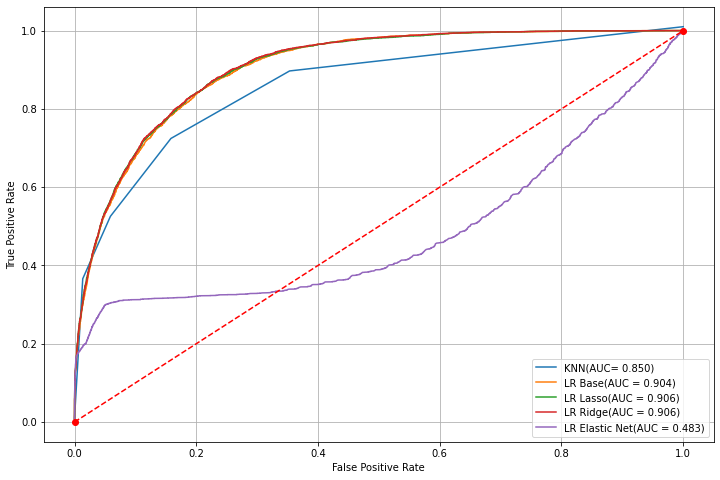

In [ ]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(fpr_nb, tpr_nb+0.01,label="KNN(AUC= %0.3f)" % roc_auc_nb)
plt.plot(fpr_lg, tpr_lg, label="LR Base(AUC = %0.3f)" % roc_auc_lg)
plt.plot(fpr_lg_l1, tpr_lg_l1, label="LR Lasso(AUC = %0.3f)" % roc_auc_lg_l1)
plt.plot(fpr_lg_l2, tpr_lg_l2, label="LR Ridge(AUC = %0.3f)" % roc_auc_lg_l2)
plt.plot(fpr_lg_en, tpr_lg_en, label="LR Elastic Net(AUC = %0.3f)" % roc_auc_lg_en)
plt.plot([0, 1], [0, 1], '--or')
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

# Binning
* Removing of certain continous variables seem to improve the shape of Elastic Net ROC curve.So another consideration is to bin the continous variables based on the information value. Elastic Net appears to be quite expensive so could not produce these results. Also there was a general consensus to leave the continous features without binning.

# Summary
* Lasso(l1) Regularization significantly improved the oveall prediction power of the model, as evidenced by Matthew's correlation coefficeint and AUC statistics.  
* The accuracy of Logistic Regression with Lasso(L1/Training) is: 0.852. The accuracy of Logistic Regression with Lasso(L1/Test) is: 0.853. So the model ranking was preserved when applied on test data.
* Some of the solving methods like ‘newton-cg’  failed to converge when the hyperparameter search function was used. The ones provided l2 hyperparameters did not seem to have significant lift compared to the baseline.  
* ElasticNet and 'saga' solving method are very slow but converged with a 3,000 iteration. More need to be explored on their low lift to baseline.

@ Jeomoan Francis Kurian

In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

iv, woe = iv_woe(data = df, target = 'Income', bins=10, show_woe = True)
print(iv)
# print(woe)
